Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_4               │ (None, 20)             │             0 │
│ (EmbeddingLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,604 (6.27 KB)

 Trainable params: 1,604 (6.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6641 - loss: 0.8516 - val_accuracy: 0.7912 - val_loss: 0.5806
Epoch 2/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7820 - loss: 0.6145 - val_accuracy: 0.7968 - val_loss: 0.5659
Epoch 3/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7859 - loss: 0.6014 - val_accuracy: 0.8002 - val_loss: 0.5606
Epoch 4/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7907 - loss: 0.5931 - val_accuracy: 0.8014 - val_loss: 0.5568
Epoch 5/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7919 - loss: 0.5886 - val_accuracy: 0.8017 - val_loss: 0.5556
Epoch 6/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7935 - loss: 0.5864 - val_accuracy: 0.8008 - val_loss: 0.5547
Epoch 7/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7941 - loss: 0.5862 - val_accuracy: 0.8015 - val_loss: 0.5533
Epoch 8/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7953 - loss: 0.5792 - val

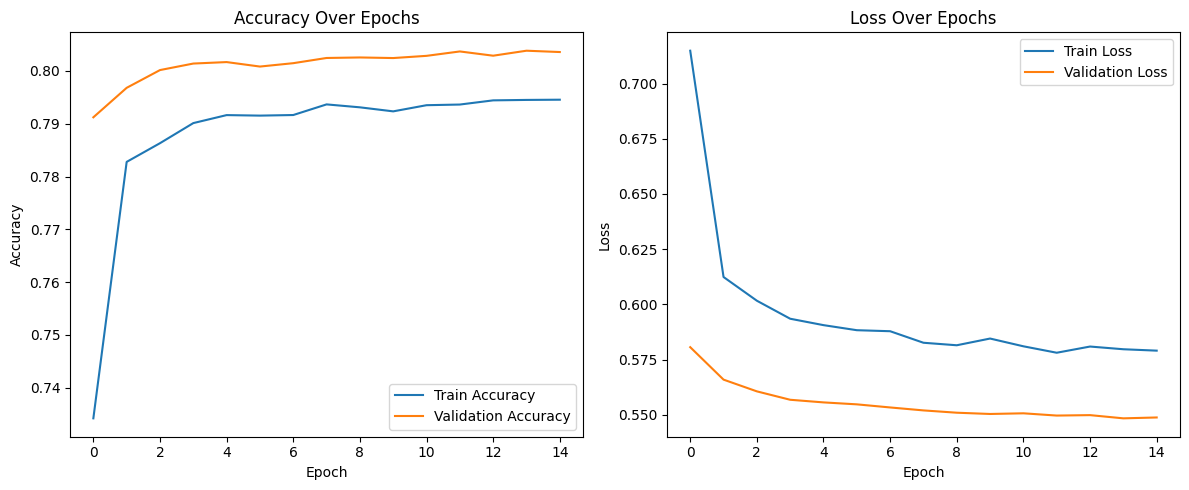

In [7]:
#Multi-class Text Classification using TensorFlow and Pretrained Embendings.

"""Dataset:AG News Subset
Model:Pretrained Swivel Embendding Layer + Dense Neural Network
Goal:Classify news healines into one 4 catagories(World, Sports, Business, Sci/Tech)
Embendding Source:Google News Swivel 20-dimensional embendding from Kaggle (TensorFlow Hub)
Loss Function:Categorial Crossentropy (with one-hot encoded labels)
Optimizer:Adam
Metrics:Accuracy"""

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


train_data, val_data, test_data=tfds.load(
    name="ag_news_subset",
    split=['train[:60%]', 'train[40%:]', 'test'],
    as_supervised=True
)

def preprocess(text,label):
    text=tf.strings.lower(text)
    label=tf.one_hot(label,depth=4)
    return text, label

train_data = train_data.map(preprocess).shuffle(1000).batch(100).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess).batch(100).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(100).prefetch(tf.data.AUTOTUNE)
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.hub_layer=hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
        trainable=True

        )
    def call(self,inputs):
        return self.hub_layer(inputs)

text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
embedding=EmbeddingLayer()(text_input)
x=tf.keras.layers.Dense(64,activation='relu')(embedding)
y=tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(y)
model = tf.keras.Model(inputs=text_input, outputs=output)


model=tf.keras.Model(inputs=text_input,outputs=output)
model.summary()



model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history=model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[early_stop]

)

model.evaluate(test_data)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()






